In [2]:
!pip install pandarallel torchvision -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.3 MB/s eta 0:00:00


In [3]:
ROOT_PATH = "/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project"

In [41]:
import os

def count_files(directory):
    file_count = 0

    for root, dirs, files in os.walk(directory):
        current_folder_files = len(files)
        print(f"Folder: {root} - Number of files: {current_folder_files}")
        file_count += current_folder_files

    return file_count

directory_path = '/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_preprocessed'
num_files = count_files(directory_path)
print(f"Total number of files in {directory_path} and its subdirectories: {num_files}")


Folder: /content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_preprocessed - Number of files: 3
Folder: /content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_preprocessed/eval - Number of files: 0
Folder: /content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_preprocessed/eval/hateful - Number of files: 250
Folder: /content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_preprocessed/eval/non_hateful - Number of files: 250
Folder: /content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_preprocessed/train - Number of files: 0
Folder: /content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_preprocessed/train/hateful - Number of files: 3036
Folder: /content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_preprocessed/train/non_hateful - Number of files: 5450
Total number of files in /content/d

In [4]:
import os
import shutil
import numpy as np
import pandas as pd
import json


In [5]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
from pandarallel import pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

pandarallel.initialize(nb_workers=num_processors, use_memory_fs=False, progress_bar=True)

Available CPUs: 4
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [7]:
TRAIN_JSONL_PATH = os.path.join(ROOT_PATH, "data_raw/train.jsonl")
EVAL_JSONL_PATH =  os.path.join(ROOT_PATH, "data_raw/dev.jsonl")
TEST_JSONL_PATH =  os.path.join(ROOT_PATH, "data_raw/test.jsonl")

### Read the Data

In [41]:
def read_jsonl(path):
    # Open the JSONL file
    with open(path, 'r') as file:
        data_list = []
        
        # Read each line in the file
        for line in file:
            # Parse the JSON data from each line
            data = json.loads(line)
            
            # Append the JSON data to the list
            data_list.append(data)

    # Create a Pandas DataFrame from the list of JSON objects
    df = pd.DataFrame(data_list)
    return df

train = read_jsonl(TRAIN_JSONL_PATH)
eval_df = read_jsonl(EVAL_JSONL_PATH)
test = read_jsonl(TEST_JSONL_PATH)

In [42]:
train.shape

(8500, 4)

In [43]:
eval_df.shape

(500, 4)

In [44]:
train["dataset"] = "train"
eval_df["dataset"] = "eval"
test["dataset"] = "test"

main_df = pd.concat([train, eval_df, test], ignore_index=True)
main_df.head()

,id,img,label,text,dataset
0,42953,img/42953.png,0.0,its their character not their color that matters,train
1,23058,img/23058.png,0.0,don't be afraid to love again everyone is not ...,train
2,13894,img/13894.png,0.0,putting bows on your pet,train
3,37408,img/37408.png,0.0,i love everything and everybody! except for sq...,train
4,82403,img/82403.png,0.0,"everybody loves chocolate chip cookies, even h...",train


In [45]:
df = main_df.copy()

In [46]:
del train
del eval_df
del test

In [13]:
# replace the values in the label column from 0,1 to non_hateful and hateful
df["label"] = df["label"].replace({0.0: "non_hateful", 1.0: "hateful"})

In [14]:
df["img"] = os.path.join(ROOT_PATH, "data_raw/") + df["img"].astype(str)

In [15]:
df["img"][1]

'/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_raw/img/23058.png'

### Organize the data

In [ ]:
import os

# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [ ]:
ROOT_PATH

'/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project'

In [ ]:
print(f"gsutil -m cp -r gs://machine-learning-spring-2023/data_preprocessed {ROOT_PATH}/")

gsutil -m cp -r gs://machine-learning-spring-2023/data_preprocessed /content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/


In [ ]:
## TAKES APPROX. 3 MINS
# Copy the files from GCS to the current working directory in colab
os.system(f'gsutil -m cp -r gs://machine-learning-spring-2023/data_preprocessed {ROOT_PATH}/')
# os.system('gsutil cp -r gs://mybucket/folder2 .')
# os.system('gsutil cp -r gs://mybucket/folder3 .')

2

In [ ]:
TARGET_MODEL_DATAPATH = "/content/drive/MyDrive/UChicago_MachineLearning"

In [ ]:
df[(df['dataset'] == "train") & (df['label'] == "hateful")]['img'].iloc[0]

'/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_raw/img/79351.png'

In [ ]:
import os
import shutil

unique_datasets = df['dataset'].unique()

for dataset in unique_datasets:
    dataset_folder = os.path.join(TARGET_MODEL_DATAPATH, "data_preprocessed", dataset)
    print(dataset_folder)
    os.makedirs(dataset_folder, exist_ok=True)

    dataset_classes = df[df['dataset'] == df]['label'].unique()
    if len(dataset_classes) == 1:
        continue

    for class_name in dataset_classes:
        print(class_name)
        class_folder = os.path.join(dataset_folder, str(class_name))
        os.makedirs(class_folder, exist_ok=True)

        class_images = df[(df['dataset'] == dataset) & (df['label'] == class_name)]['img']
        print(class_images.shape)
        for image_path in class_images:
            image_name = os.path.basename(image_path)
            destination_path = os.path.join(class_folder, image_name)
            shutil.copy(image_path, destination_path)
        

print("Image copying completed successfully.")

/content/drive/MyDrive/UChicago_MachineLearning/data_preprocessed/train


<ipython-input-51-cd17501b54f3>:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  dataset_classes = df[df['dataset'] == df]['label'].unique()


/content/drive/MyDrive/UChicago_MachineLearning/data_preprocessed/eval


<ipython-input-51-cd17501b54f3>:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  dataset_classes = df[df['dataset'] == df]['label'].unique()


/content/drive/MyDrive/UChicago_MachineLearning/data_preprocessed/test


<ipython-input-51-cd17501b54f3>:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  dataset_classes = df[df['dataset'] == df]['label'].unique()


Image copying completed successfully.


In [ ]:
gsutil cp -r gs://machine-learning-spring-2023/data_preprocessed .


In [ ]:
%ls "/content/drive/MyDrive/UChicago_MachineLearning/data_preprocessed/train"

In [ ]:
df = df.head(1000)

### Pixel Processing

In [ ]:
def crop_center(img):
    y, x, _ = img.shape
    startx = x//2-(224//2)
    starty = y//2-(224//2)    
    return img[starty:starty+224, startx:startx+224, :]

In [ ]:
%ls -al

total 20
drwxr-xr-x 1 root root 4096 May 23 20:19 ./
drwxr-xr-x 1 root root 4096 May 23 20:03 ../
drwxr-xr-x 4 root root 4096 May 22 13:32 .config/
drwx------ 6 root root 4096 May 23 20:19 drive/
drwxr-xr-x 1 root root 4096 May 22 13:33 sample_data/


In [ ]:
from PIL import Image

def load_image_pixels(image_path):
    # Open the image file
    try:
        with Image.open(image_path) as img:
            # Convert the image to RGB (if it's not already in that format)
            img = img.convert('RGB')
            # Get the pixel values as a numpy array and flatten it
            pixels = np.array(img)
            pixels = crop_center(pixels)
            pixels = np.divide(pixels, 255)
            pixels = np.squeeze(pixels
                                )
            return pixels
    except:
        return ""


# Add a new column 'pixels' to the DataFrame
df['pixels'] = df['img'].parallel_apply(load_image_pixels)

KeyboardInterrupt: ignored

In [ ]:
output_path = "/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/image_pixels.pkl"

In [ ]:
df.to_pickle(output_path)

### Read the Pixel Data

In [16]:
output_path = "/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/image_pixels.pkl"

In [17]:
df = pd.read_pickle(output_path)

In [18]:
print("Length before processing: ", df.shape)
df = df[df.pixels != ""]
print("Length after processing: ", df.shape)


Length before processing:  (10000, 6)
Length after processing:  (4042, 6)


/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [19]:
df.head()

,id,img,label,text,dataset,pixels
0,42953,/content/drive/MyDrive/UChicago_MachineLearnin...,non_hateful,its their character not their color that matters,train,"[[[0.3137254901960784, 0.30196078431372547, 0...."
3,37408,/content/drive/MyDrive/UChicago_MachineLearnin...,non_hateful,i love everything and everybody! except for sq...,train,"[[[0.5490196078431373, 0.5450980392156862, 0.5..."
4,82403,/content/drive/MyDrive/UChicago_MachineLearnin...,non_hateful,"everybody loves chocolate chip cookies, even h...",train,"[[[0.043137254901960784, 0.043137254901960784,..."
7,70914,/content/drive/MyDrive/UChicago_MachineLearnin...,non_hateful,tattoos are bad for your health i know 5 milli...,train,"[[[0.8313725490196079, 0.8, 0.7529411764705882..."
12,25489,/content/drive/MyDrive/UChicago_MachineLearnin...,hateful,brother... a day without a blast is a day wasted,train,"[[[0.7294117647058823, 0.5490196078431373, 0.4..."


In [20]:
df.dataset.value_counts()

train    3399
test      423
eval      220
Name: dataset, dtype: int64

In [17]:
# df = df.head(1000)

### Modeling

In [21]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [22]:
df["pixels"][0].shape

(224, 224, 3)

In [23]:
import numpy as np
from torchvision import transforms

def calculate_mean_std(dataset):
    """
    Calculate the mean and standard deviation of a dataset.
    
    Args:
        dataset: PyTorch dataset object.
        
    Returns:
        mean: List of mean values for each channel.
        std: List of standard deviation values for each channel.
    """
    # Initialize lists to store channel-wise mean and std
    mean = [0.0, 0.0, 0.0]
    std = [0.0, 0.0, 0.0]

    # Loop over the dataset to calculate mean and std
    for idx, image in enumerate(dataset):
        try:
            for i in range(3):  # Assuming 3 channels (RGB)
                mean[i] += image[:, :, i].mean()
                std[i] += image[:, :, i].std()
        except:
            print(f"Error with Index {idx}")


    # Calculate the average mean and std across the dataset
    mean = [m / len(dataset) for m in mean]
    std = [s / len(dataset) for s in std]

    return mean, std

# Calculate the mean and std for the training set
mean, std = calculate_mean_std(df['pixels'])

Error with Index 2906


In [25]:
mean, std

([0.5149958556130754, 0.45956921375635357, 0.42985640392557245],
 [0.24312528523774807, 0.2351713949596656, 0.23576431541623782])

### Transformation

In [68]:
df

,id,img,label,text,dataset
0,42953,img/42953.png,0.0,its their character not their color that matters,train
1,23058,img/23058.png,0.0,don't be afraid to love again everyone is not ...,train
2,13894,img/13894.png,0.0,putting bows on your pet,train
3,37408,img/37408.png,0.0,i love everything and everybody! except for sq...,train
4,82403,img/82403.png,0.0,"everybody loves chocolate chip cookies, even h...",train
...,...,...,...,...,...
9995,3869,img/03869.png,NaN,a mother's love for the child is a divine thing,test
9996,23817,img/23817.png,NaN,sea monkeys,test
9997,56280,img/56280.png,NaN,little miss muffet sat on her tuffet,test
9998,29384,img/29384.png,NaN,they're in a row,test


In [75]:
from torch.utils.data import Dataset

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths."""
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [76]:
BATCH_SIZE = 32

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),  # Resize all images to 224 x 224

        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize all images to 224 x 224
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),
}

data_dir = "/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_preprocessed/"

image_datasets = {x: ImageFolderWithPaths(data_dir + x, data_transforms[x])
                  for x in ['train', 'eval']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'eval']}
              
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [62]:
dataset_sizes

{'train': 8486, 'eval': 500}

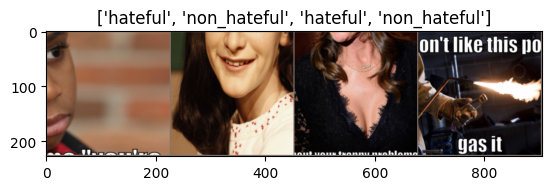

In [ ]:
def imshow(inp, mean, std, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, mean, std, title=[class_names[x] for x in classes])

### Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_per_epoch = []
    eval_loss_per_epoch = []

    train_acc_per_epoch = []
    eval_acc_per_epoch = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_loss_per_epoch.append(epoch_loss)
                train_acc_per_epoch.append(epoch_acc.item())
            elif phase == 'eval':
                eval_loss_per_epoch.append(epoch_loss)
                eval_acc_per_epoch.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, {"train_losses": train_loss_per_epoch, 
                   "test_losses": eval_loss_per_epoch,
                   "train_accuracies": train_acc_per_epoch,
                   "eval_accuracies": eval_acc_per_epoch
                   }

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
%%time

try:
    model_ft, metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)
except Exception as e:
    raise Exception(e)
finally:
    print(metrics)

Epoch 0/19
----------
train Loss: 0.8379 Acc: 0.5698
eval Loss: 0.7174 Acc: 0.5104

Epoch 1/19
----------
train Loss: 0.7186 Acc: 0.6016
eval Loss: 0.6572 Acc: 0.6455

Epoch 2/19
----------
train Loss: 0.7006 Acc: 0.6111
eval Loss: 0.6615 Acc: 0.6257

Epoch 3/19
----------
train Loss: 0.6910 Acc: 0.6142
eval Loss: 0.6979 Acc: 0.6439

Epoch 4/19
----------
train Loss: 0.6741 Acc: 0.6260
eval Loss: 0.6712 Acc: 0.6521

Epoch 5/19
----------
train Loss: 0.6755 Acc: 0.6247
eval Loss: 0.6377 Acc: 0.6588

Epoch 6/19
----------
train Loss: 0.6686 Acc: 0.6263
eval Loss: 0.6458 Acc: 0.6411

Epoch 7/19
----------
train Loss: 0.6393 Acc: 0.6530
eval Loss: 0.6303 Acc: 0.6630

Epoch 8/19
----------
train Loss: 0.6390 Acc: 0.6507
eval Loss: 0.6386 Acc: 0.6607

Epoch 9/19
----------
train Loss: 0.6347 Acc: 0.6578
eval Loss: 0.6354 Acc: 0.6634

Epoch 10/19
----------
train Loss: 0.6341 Acc: 0.6587
eval Loss: 0.6421 Acc: 0.6583

Epoch 11/19
----------
train Loss: 0.6331 Acc: 0.6594
eval Loss: 0.6272 Acc

In [ ]:
def visualize_model(model, mean, std, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['eval']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j], mean=mean, std=std)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

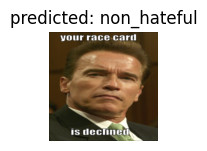

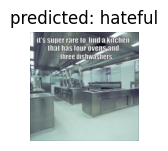

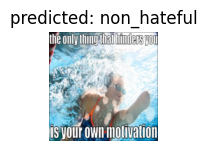

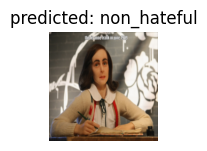

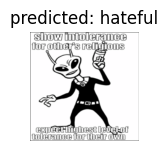

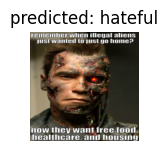

In [ ]:
visualize_model(model_ft, mean=mean, std=std)

In [ ]:
metrics

{'train_losses': [0.8378587017180034,
  0.7185671639743066,
  0.7006370623087,
  0.6910241164957159,
  0.6741008267575718,
  0.6755293594577136,
  0.6686075033162131,
  0.6393027293802909,
  0.6390367304972537,
  0.6346590471750944,
  0.6341406968357483,
  0.6331265978365891,
  0.6337438616484593,
  0.634378069601277,
  0.6288583653520475,
  0.6295346915511177,
  0.6278542980618447,
  0.6296825431131007,
  0.6303081947018621,
  0.6261240330867376],
 'test_losses': [0.7174013494995723,
  0.6571713373075531,
  0.6615399996570729,
  0.6978588148077057,
  0.6711742162016128,
  0.637704769536175,
  0.6457576219298888,
  0.6302652476658778,
  0.6385800142895633,
  0.6354402702722295,
  0.6421354471084899,
  0.6271654008807592,
  0.623437797702935,
  0.6173080711566472,
  0.6168943388743584,
  0.6219512342620003,
  0.6253251989734024,
  0.6217427474272973,
  0.6220892845193592,
  0.6175460426798413],
 'train_accuracies': [0.5697619608767381,
  0.601579071411737,
  0.6111242045722366,
  0.6141

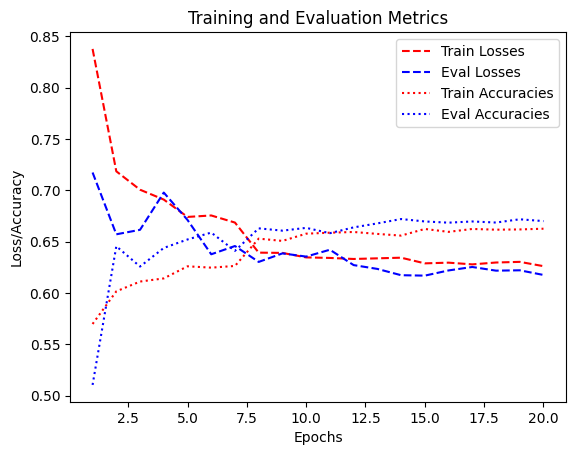

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(metrics['train_losses']) + 1)

plt.plot(list(epochs), metrics['train_losses'], 'r--', label='Train Losses')
plt.plot(list(epochs), metrics['test_losses'], 'b--', label='Eval Losses')
plt.plot(list(epochs), metrics['train_accuracies'], 'r:', label='Train Accuracies')
plt.plot(list(epochs), metrics['eval_accuracies'], 'b:', label='Eval Accuracies')

plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Training and Evaluation Metrics')
plt.legend()

plt.show()


### Feature Extraction

In [28]:
df.head()

,id,img,label,text,dataset,pixels
0,42953,/content/drive/MyDrive/UChicago_MachineLearnin...,non_hateful,its their character not their color that matters,train,"[[[0.3137254901960784, 0.30196078431372547, 0...."
3,37408,/content/drive/MyDrive/UChicago_MachineLearnin...,non_hateful,i love everything and everybody! except for sq...,train,"[[[0.5490196078431373, 0.5450980392156862, 0.5..."
4,82403,/content/drive/MyDrive/UChicago_MachineLearnin...,non_hateful,"everybody loves chocolate chip cookies, even h...",train,"[[[0.043137254901960784, 0.043137254901960784,..."
7,70914,/content/drive/MyDrive/UChicago_MachineLearnin...,non_hateful,tattoos are bad for your health i know 5 milli...,train,"[[[0.8313725490196079, 0.8, 0.7529411764705882..."
12,25489,/content/drive/MyDrive/UChicago_MachineLearnin...,hateful,brother... a day without a blast is a day wasted,train,"[[[0.7294117647058823, 0.5490196078431373, 0.4..."


In [77]:
import torch
import torchvision
import numpy as np

# Load pretrained model and modify final layer
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs, 20)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
train_ids = list(df[df.dataset=="train"]["id"])
eval_ids = list(df[df.dataset=="eval"]["id"])

In [78]:
import numpy as np
import os

# Create directory for features if not exists
os.makedirs("/content/features", exist_ok=True)

# No need for gradients as we're not training
with torch.no_grad():
    for phase in ['train', 'eval']:  # Loop over both train and eval dataloaders
        features_list = []
        labels_list = []
        paths_list = []
        for i, (inputs, labels, paths) in enumerate(dataloaders[phase]):
            print("i: ", i)
            inputs = inputs.to(device)
            labels = labels.to(device)

            features = model_conv(inputs)
            for j in range(features.size(0)):  # Loop over samples within a batch
                features_list.append(features[j].cpu().numpy())
                labels_list.append(labels[j].cpu().numpy())

            paths_list += paths
            
            # Save every 100 batches
            if i % 100 == 0 and i > 0:  # Save only if we've accumulated enough data
                # Convert lists to numpy arrays
                features_array = np.array(features_list)
                labels_array = np.array(labels_list)
                paths_list = [img_file_name.split("/")[-1] for img_file_name in paths_list]
                paths_array = np.array(paths_list)

                # Save to disk
                np.save(f"/content/features/features_{phase}_b{i}.npy", features_array)
                np.save(f"/content/features/labels_{phase}_b{i}.npy", labels_array)
                np.save(f"/content/features/paths_{phase}_b{i}.npy", paths_array)

                # Clear lists to free memory
                features_list = []
                labels_list = []
                paths_list = []

        # Save the remaining features, labels and ids if necessary
        if len(features_list) > 0:
            # Convert lists to numpy arrays
            features_array = np.array(features_list)
            labels_array = np.array(labels_list)
            paths_list = [img_file_name.split("/")[-1] for img_file_name in paths_list]
            paths_array = np.array(paths_list)

            # Save to disk
            np.save(f"/content/features/features_{phase}_b{i}.npy", features_array)
            np.save(f"/content/features/labels_{phase}_b{i}.npy", labels_array)
            np.save(f"/content/features/paths_{phase}_b{i}.npy", paths_array)



i:  0
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
i:  13
i:  14
i:  15
i:  16
i:  17
i:  18
i:  19
i:  20
i:  21
i:  22
i:  23
i:  24
i:  25
i:  26
i:  27
i:  28
i:  29
i:  30
i:  31
i:  32
i:  33
i:  34
i:  35
i:  36
i:  37
i:  38
i:  39
i:  40
i:  41
i:  42
i:  43
i:  44
i:  45
i:  46
i:  47
i:  48
i:  49
i:  50
i:  51
i:  52
i:  53
i:  54
i:  55
i:  56
i:  57
i:  58
i:  59
i:  60
i:  61
i:  62
i:  63
i:  64
i:  65
i:  66
i:  67
i:  68
i:  69
i:  70
i:  71
i:  72
i:  73
i:  74
i:  75
i:  76
i:  77
i:  78
i:  79
i:  80
i:  81
i:  82
i:  83
i:  84
i:  85
i:  86
i:  87
i:  88
i:  89
i:  90
i:  91
i:  92
i:  93
i:  94
i:  95
i:  96
i:  97
i:  98
i:  99
i:  100
i:  101
i:  102
i:  103
i:  104
i:  105
i:  106
i:  107
i:  108
i:  109
i:  110
i:  111
i:  112
i:  113
i:  114
i:  115
i:  116
i:  117
i:  118
i:  119
i:  120
i:  121
i:  122
i:  123
i:  124
i:  125
i:  126
i:  127
i:  128
i:  129
i:  130
i:  131
i:  132
i:  133
i:  134
i:  135
i:  136
i:  137
i:  13

In [86]:
import os
import numpy as np
import pandas as pd
import glob

def create_dataframe_from_npy_files():
    # Get all npy file paths
    npy_files = glob.glob("/content/features/*.npy")
    
    # Separate the file paths based on type: features, labels, and paths
    features_files = sorted([file for file in npy_files if 'features_' in file])
    labels_files = sorted([file for file in npy_files if 'labels' in file])
    paths_files = sorted([file for file in npy_files if 'paths' in file])
    
    print(len(features_files))
    print(len(labels_files))
    print(len(paths_files))

    # Initialize empty lists to store all the data
    all_features = []
    all_labels = []
    all_paths = []

    # Read and append all the data
    for f_file, l_file, p_file in zip(features_files, labels_files, paths_files):
        features = np.load(f_file)
        labels = np.load(l_file)
        paths = np.load(p_file)

        # Assuming that the feature vectors are flattened
        # and each feature vector has a length of 20
        all_features.extend(features)
        all_labels.extend(labels)
        all_paths.extend(paths)

    # Convert the lists to a DataFrame
    df = pd.DataFrame(all_features, columns=[f'feature_{i}' for i in range(20)])
    df['label'] = all_labels
    df['path'] = all_paths

    return df

feature_df = create_dataframe_from_npy_files()

4
4
4


In [87]:
feature_df.shape

(8986, 22)

In [91]:
feature_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,label,path
0,0.530085,0.488977,-0.113115,0.015020,-0.027616,-0.427606,-0.750996,0.011548,0.858244,0.132496,...,0.027083,-0.829091,-0.384014,0.025911,0.547540,0.153630,0.266383,0.455937,0,01456.png
1,0.303321,-0.136549,-0.679844,0.259443,-0.509942,-0.401917,-0.264162,0.396859,-0.031298,0.059598,...,-0.489851,-0.212876,-1.285323,0.260769,1.072918,0.387688,-0.013143,-0.210215,0,01726.png
2,-0.067749,-0.180159,-1.306831,0.213957,0.266355,0.181536,0.292081,-0.296363,0.891020,-0.501828,...,-0.212977,-0.301951,-0.592484,-0.284378,0.074950,0.531769,0.275458,0.189499,0,01765.png
3,0.665094,0.182436,-0.287966,-0.169398,0.269944,0.081864,-0.097685,0.088677,0.409557,0.743116,...,-0.797883,-0.107612,-1.197587,-0.107875,0.489352,0.032808,0.393425,0.385427,0,01796.png
4,0.018574,0.498051,-0.479313,-0.028792,-0.145709,0.267059,0.150578,-0.161765,0.767828,0.412825,...,-0.032746,-0.354098,-0.308409,0.656898,1.045326,0.049474,-0.052531,-0.018084,0,01925.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,0.629275,0.780988,-0.913025,-0.334055,-0.743344,0.061763,0.039855,0.137024,0.910905,1.158869,...,-1.209888,-0.218239,-0.705100,0.545868,0.680361,-0.089224,0.224666,0.102888,1,98731.png
8982,0.476889,0.117571,-0.436004,-0.223811,-0.653168,-0.422667,0.283257,-0.072312,0.698379,0.650873,...,-0.513341,-0.697376,-0.296064,0.304151,0.652909,-0.124514,0.076046,0.226159,1,98751.png
8983,0.612848,0.098404,0.271644,0.129210,1.128639,-0.890068,0.062885,0.398054,0.309193,-0.296326,...,0.091736,0.217110,-0.962456,0.679252,0.347304,0.343265,0.060043,0.332320,1,98752.png
8984,0.537348,0.045794,-0.351427,-0.309101,0.298712,0.010709,-0.658435,0.294491,0.482246,-0.384276,...,-0.319692,-0.280747,-0.787528,-0.351044,0.160047,0.224092,0.197607,0.350534,1,98762.png


In [93]:
main_df["img_name"] = main_df["img"].parallel_apply(lambda t: t.split("/")[-1])

In [94]:
main_df

,id,img,label,text,dataset,img_name
0,42953,img/42953.png,0.0,its their character not their color that matters,train,42953.png
1,23058,img/23058.png,0.0,don't be afraid to love again everyone is not ...,train,23058.png
2,13894,img/13894.png,0.0,putting bows on your pet,train,13894.png
3,37408,img/37408.png,0.0,i love everything and everybody! except for sq...,train,37408.png
4,82403,img/82403.png,0.0,"everybody loves chocolate chip cookies, even h...",train,82403.png
...,...,...,...,...,...,...
9995,3869,img/03869.png,NaN,a mother's love for the child is a divine thing,test,03869.png
9996,23817,img/23817.png,NaN,sea monkeys,test,23817.png
9997,56280,img/56280.png,NaN,little miss muffet sat on her tuffet,test,56280.png
9998,29384,img/29384.png,NaN,they're in a row,test,29384.png


In [95]:
final_df = feature_df.set_index("path").join(main_df[["id", "img_name", "text"]].set_index("img_name"), how="left").reset_index(drop=False)

In [96]:
final_df

,path,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,label,id,text
0,01456.png,0.530085,0.488977,-0.113115,0.015020,-0.027616,-0.427606,-0.750996,0.011548,0.858244,...,-0.829091,-0.384014,0.025911,0.547540,0.153630,0.266383,0.455937,0,1456,they see them rollin..... they hating..
1,01726.png,0.303321,-0.136549,-0.679844,0.259443,-0.509942,-0.401917,-0.264162,0.396859,-0.031298,...,-0.212876,-1.285323,0.260769,1.072918,0.387688,-0.013143,-0.210215,0,1726,a real man loads the dishwasher every night
2,01765.png,-0.067749,-0.180159,-1.306831,0.213957,0.266355,0.181536,0.292081,-0.296363,0.891020,...,-0.301951,-0.592484,-0.284378,0.074950,0.531769,0.275458,0.189499,0,1765,"after a girl dies, what organ in her body stay..."
3,01796.png,0.665094,0.182436,-0.287966,-0.169398,0.269944,0.081864,-0.097685,0.088677,0.409557,...,-0.107612,-1.197587,-0.107875,0.489352,0.032808,0.393425,0.385427,0,1796,life hack #23 how to get stoned with no weed
4,01925.png,0.018574,0.498051,-0.479313,-0.028792,-0.145709,0.267059,0.150578,-0.161765,0.767828,...,-0.354098,-0.308409,0.656898,1.045326,0.049474,-0.052531,-0.018084,0,1925,i am not racist i just don't like brown sugar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,98731.png,0.629275,0.780988,-0.913025,-0.334055,-0.743344,0.061763,0.039855,0.137024,0.910905,...,-0.218239,-0.705100,0.545868,0.680361,-0.089224,0.224666,0.102888,1,98731,who farted ?
8982,98751.png,0.476889,0.117571,-0.436004,-0.223811,-0.653168,-0.422667,0.283257,-0.072312,0.698379,...,-0.697376,-0.296064,0.304151,0.652909,-0.124514,0.076046,0.226159,1,98751,"""the other day i was sucking my sister and she..."
8983,98752.png,0.612848,0.098404,0.271644,0.129210,1.128639,-0.890068,0.062885,0.398054,0.309193,...,0.217110,-0.962456,0.679252,0.347304,0.343265,0.060043,0.332320,1,98752,shut up ontario
8984,98762.png,0.537348,0.045794,-0.351427,-0.309101,0.298712,0.010709,-0.658435,0.294491,0.482246,...,-0.280747,-0.787528,-0.351044,0.160047,0.224092,0.197607,0.350534,1,98762,child in poverty with empty water jug


In [90]:
target_csv_path = ROOT_PATH + "/data_preprocessed/image_features.csv"
print(target_csv_path)

/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_preprocessed/image_features.csv


In [ ]:
final_df.to_csv(target_csv_path)